# Three-layer fully connected network in Keras library

In [1]:
#Add the LiveLoosPlot library and import it. This library will enable you to draw the learning results (loss vs epochs function) in real time.
!pip install livelossplot

In [37]:
from livelossplot import PlotLossesKeras
%matplotlib inline

#You need to install an older version of tensorflow for the example to work
!pip uninstall tensorflow -y
!pip install --user tensorflow==2.8.0

Found existing installation: tensorflow 2.16.2
Uninstalling tensorflow-2.16.2:
  Successfully uninstalled tensorflow-2.16.2
  Using cached tensorflow-2.8.0-cp310-cp310-win_amd64.whl.metadata (2.9 kB)
  Using cached tensorboard-2.8.0-py3-none-any.whl.metadata (1.9 kB)
  Using cached keras-2.8.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl.metadata (1.1 kB)
Using cached tensorflow-2.8.0-cp310-cp310-win_amd64.whl (438.0 MB)
Using cached keras-2.8.0-py2.py3-none-any.whl (1.4 MB)
Using cached tensorboard-2.8.0-py3-none-any.whl (5.8 MB)
Using cached tensorboard_data_server-0.6.1-py3-none-any.whl (2.4 kB)


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-intel 2.16.2 requires keras>=3.0.0, but you have keras 2.8.0 which is incompatible.
tensorflow-intel 2.16.2 requires tensorboard<2.17,>=2.16, but you have tensorboard 2.8.0 which is incompatible.


In [38]:
from tensorflow import keras
print(keras.__version__)

2.8.0


In [39]:
import numpy as np                   # advanced math library
import matplotlib.pyplot as plt      # MATLAB like plotting routines
import random                        # for generating random numbers
import tensorflow as tf

from keras.datasets import mnist     # MNIST dataset is included in Keras
from keras.models import Sequential  # Model type to be used

from keras.layers.core import Dense, Dropout, Activation # Types of layers to be used in our model
from keras.utils import np_utils                         # NumPy related tools

### Loading Training Data

The MNIST dataset is conveniently bundled within Keras, and we can easily analyze some of its features in Python.

In [41]:
# The MNIST data is split between 60,000 28 x 28 pixel training images and 10,000 28 x 28 pixel images
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print("X_train shape", X_train.shape)
print("y_train shape", y_train.shape)
print("X_test shape", X_test.shape)
print("y_test shape", y_test.shape)

X_train shape (60000, 28, 28)
y_train shape (60000,)
X_test shape (10000, 28, 28)
y_test shape (10000,)


Using matplotlib, we can plot some sample images from the training set directly into this Jupyter Notebook.

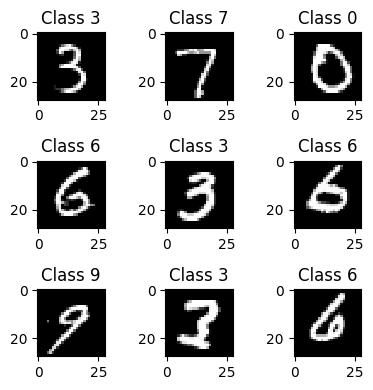

In [40]:
plt.rcParams['figure.figsize'] = (4,4) # Make the figures a bit bigger

for i in range(9):
    plt.subplot(3,3,i+1)
    num = random.randint(0, len(X_train))
    plt.imshow(X_train[num], cmap='gray', interpolation='none')
    plt.title("Class {}".format(y_train[num]))

plt.tight_layout()

Let's examine a single digit a little closer, and print out the array representing the last digit.

In [42]:
#Just a little function for pretty printing a matrix
def matprint(mat, fmt="g"):
    col_maxes = [max([len(("{:"+fmt+"}").format(x)) for x in col]) for col in mat.T]
    for x in mat:
        for i, y in enumerate(x):
            print(("{:"+str(col_maxes[i])+fmt+"}").format(y), end="  ")
        print("")

# now print!
matprint(X_train[num])

0  0  0  0  0  0   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  0  
0  0  0  0  0  0   0    0    0    0    0    0    0    0    0    0    0    0    0    0    0  0  0  0  0  0  0  0  
0  0  0  0  0  0   0    0    0    0    0    0    0    0    0    0    0    0   46  217  158  0  0  0  0  0  0  0  
0  0  0  0  0  0   0    0    0    0    0    0    0    0    0    0    0   26  222  254  233  0  0  0  0  0  0  0  
0  0  0  0  0  0   0    0    0    0    0    0    0    0    0    0    0  204  253  254  165  0  0  0  0  0  0  0  
0  0  0  0  0  0   0    0    0    0    0    0    0    0    0   26  166  251  253  169   25  0  0  0  0  0  0  0  
0  0  0  0  0  0   0    0    0    0    0    0    0    0   23  207  253  253  215   23    0  0  0  0  0  0  0  0  
0  0  0  0  0  0   0    0    0    0    0    0    0    0  141  254  254  254   96    0    0  0  0  0  0  0  0  0  
0  0  0  0  0  0   0    0    0    0    0    0    0   91  254  253  253   92    9    0   

Each pixel is an 8-bit integer from 0-255. 0 is full black, while 255 is full white. This what we call a single-channel pixel. It's called monochrome.

## FULLY CONNECTED NEURAL NETWORK

In [43]:
#Flattening
X_train = X_train.reshape(60000, 784) # reshape 60,000 28 x 28 matrices into 60,000 784-length vectors.
X_test = X_test.reshape(10000, 784)   # reshape 10,000 28 x 28 matrices into 10,000 784-length vectors.

X_train = X_train.astype('float32')   # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                        # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


In [44]:
nb_classes = 10 # number of unique digits

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

### Building a 3-layer fully connected network (FCN) in KERAS

In [45]:
#The Sequential model is a linear stack of layers and is very common.
model = Sequential()
model.add(Dense(512, input_shape=(784,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('softmax'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 512)               401920    
                                                                 
 activation_12 (Activation)  (None, 512)               0         
                                                                 
 dropout_4 (Dropout)         (None, 512)               0         
                                                                 
 dense_9 (Dense)             (None, 512)               262656    
                                                                 
 activation_13 (Activation)  (None, 512)               0         
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_10 (Dense)            (None, 10)               

### Compiling the model

In [46]:
#Let's use the Adam optimizer for learning
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#SGD - Stochastic Gradient Descent

### Train the model

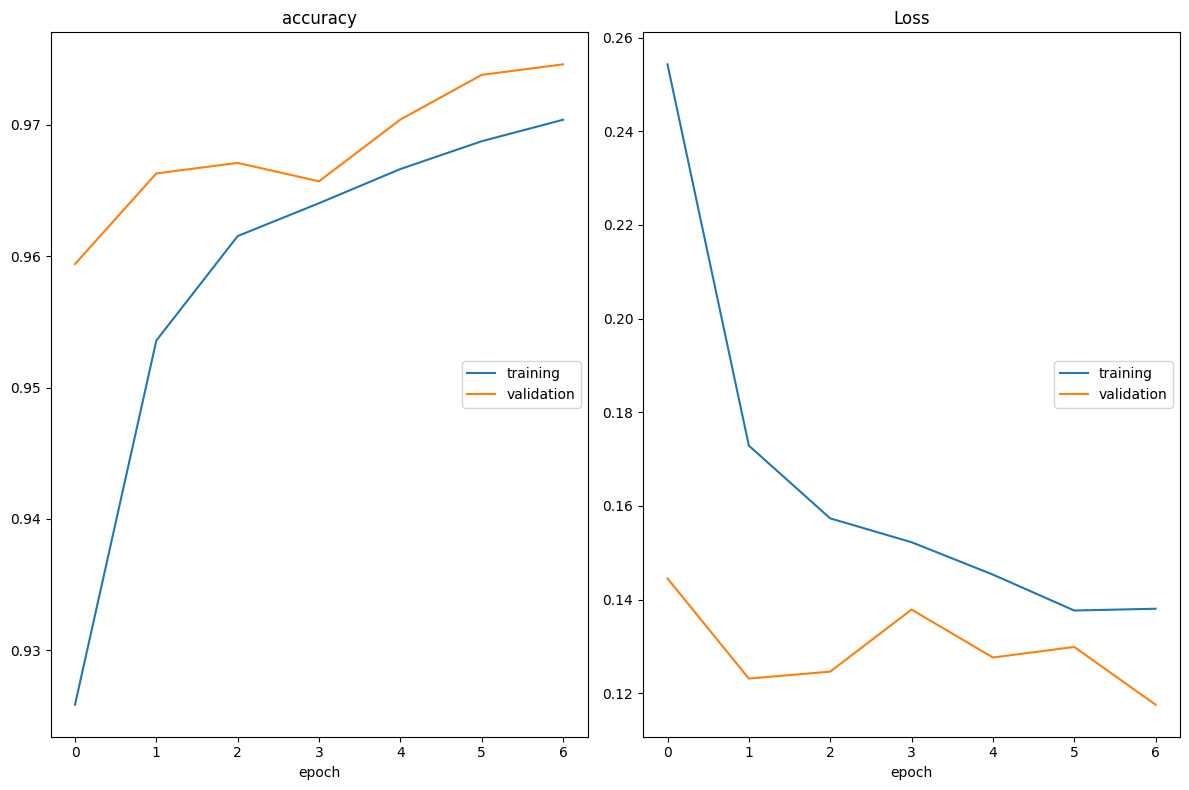

accuracy
	training         	 (min:    0.926, max:    0.970, cur:    0.970)
	validation       	 (min:    0.959, max:    0.975, cur:    0.975)
Loss
	training         	 (min:    0.138, max:    0.254, cur:    0.138)
	validation       	 (min:    0.118, max:    0.145, cur:    0.118)


In [14]:
model.fit(X_train, Y_train,
          batch_size=4, 
          epochs=7,
          validation_data=(X_test, Y_test),
          callbacks=[PlotLossesKeras()],
          verbose=0)

### Evaluate Model's Accuracy on Test Data

In [15]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 1s 2ms/step - loss: 0.1176 - accuracy: 0.9746
Test score: 0.1175609827041626
Test accuracy: 0.9746000170707703


### Inspecting the output

In [16]:
#CODE FOR OLD VERSION OF KERAS LIBRARY - NOW NOT WORKING
predicted_classes = model.predict_classes(X_test)

correct_indices = np.nonzero(predicted_classes == y_test)[0]

incorrect_indices = np.nonzero(predicted_classes != y_test)[0]

AttributeError: 'Sequential' object has no attribute 'predict_classes'

In [17]:
#REVISED CODE FOR NEW VERSION OF KERAS LIBRARY
predicted_classes = model.predict(X_test)
print(predicted_classes)

[[0.00000000e+00 5.86071955e-30 4.47473065e-25 ... 1.00000000e+00
  4.32766032e-37 5.78646249e-20]
 [0.00000000e+00 8.73951333e-37 1.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]
 [1.01574797e-22 1.00000000e+00 1.73678766e-13 ... 2.59330209e-12
  1.38081558e-14 5.56224831e-17]
 ...
 [0.00000000e+00 3.13683538e-24 3.95789235e-26 ... 1.17300553e-14
  1.99087099e-22 2.31835662e-11]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  8.83316695e-28 0.00000000e+00]
 [1.74351434e-33 0.00000000e+00 0.00000000e+00 ... 0.00000000e+00
  0.00000000e+00 0.00000000e+00]]


In [18]:
classes_x = np.argmax(predicted_classes, axis=1)
print(classes_x)

[7 2 1 ... 4 5 6]


In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, classes_x)

array([[ 968,    2,    0,    0,    0,    1,    5,    2,    1,    1],
       [   0, 1125,    1,    1,    0,    1,    1,    1,    5,    0],
       [   3,    1,  999,    0,    2,    1,    0,   14,   12,    0],
       [   1,    0,    0,  992,    0,    3,    0,    7,    3,    4],
       [   1,    1,    1,    0,  949,    0,    5,    6,    0,   19],
       [   3,    0,    0,   18,    1,  841,   15,    1,    5,    8],
       [   4,    2,    0,    1,    2,    2,  941,    0,    6,    0],
       [   1,    4,    1,    5,    0,    0,    0, 1015,    1,    1],
       [   4,    0,    2,    2,    3,    5,    1,    3,  945,    9],
       [   3,    2,    0,    6,   10,    2,    0,   13,    2,  971]],
      dtype=int64)

[7 2 1 ... 4 5 6]


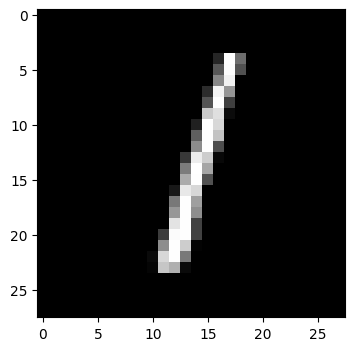

In [20]:
correct_indices = np.nonzero(classes_x == y_test)[0]
incorrect_indices = np.nonzero(classes_x != y_test)[0]
print(classes_x)
plt.imshow(X_test[2].reshape(28,28), cmap='gray', interpolation='none')

### Examples of correct and incorrect ropositions

<Figure size 400x400 with 0 Axes>

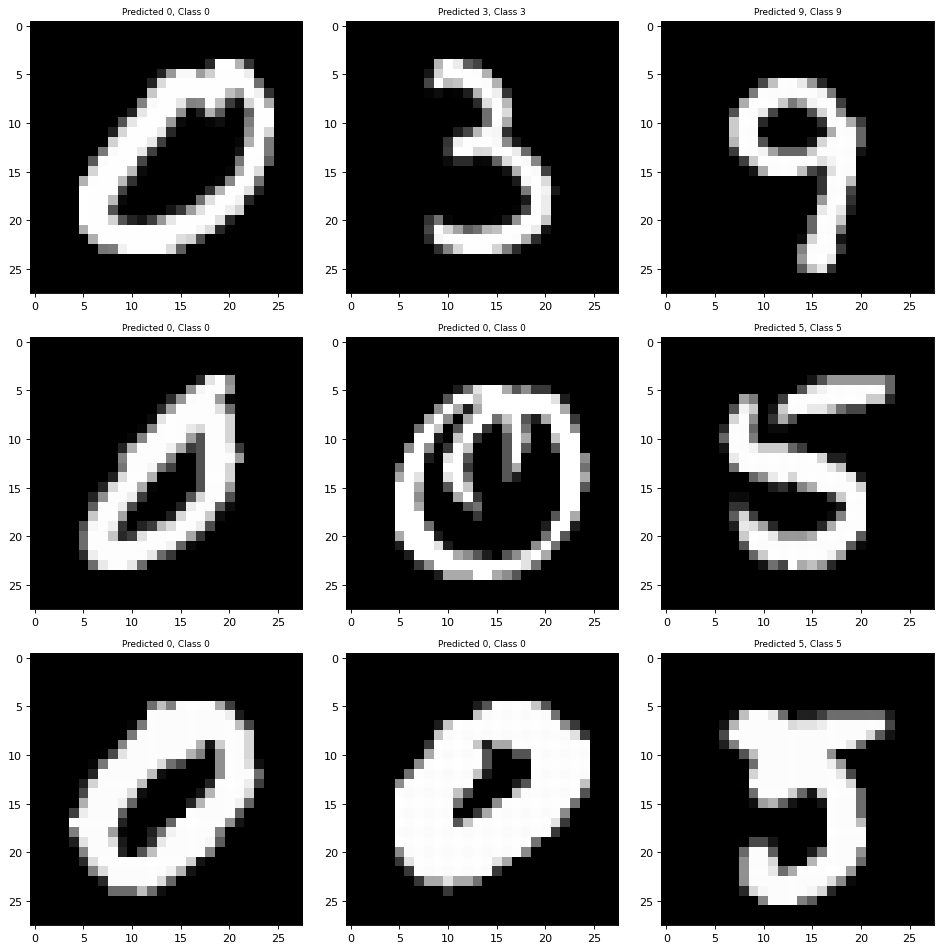

In [21]:
#CORRECT ROPOSITIONS
from matplotlib.pyplot import figure

np.random.shuffle(correct_indices)

plt.figure()
figure(figsize=(12, 12), dpi=80)
for i, correct in enumerate(correct_indices[:9]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(classes_x[correct], y_test[correct]), fontsize = 8)

plt.tight_layout()

<Figure size 400x400 with 0 Axes>

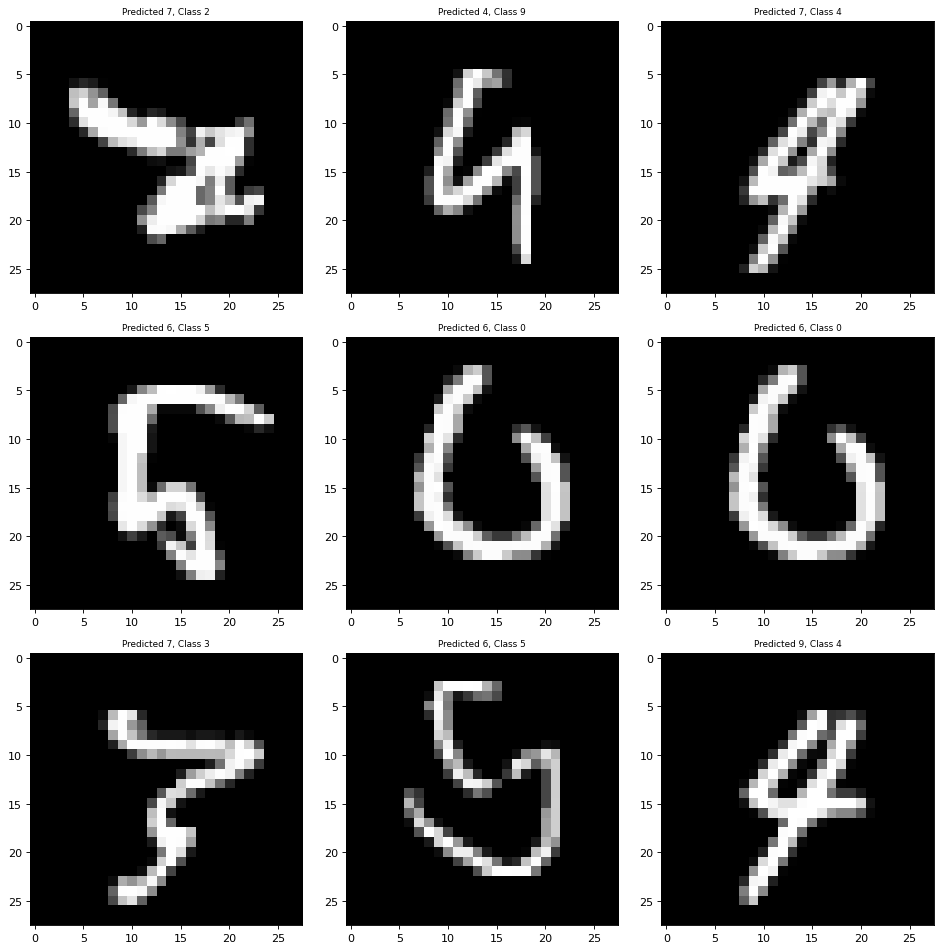

In [22]:
#INCORRECT ROPOSITIONS
shuffled_incorrect_indices = np.random.choice(incorrect_indices,9)

plt.figure()
figure(figsize=(12, 12), dpi=80)
for i, incorrect in enumerate(shuffled_incorrect_indices):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(classes_x[incorrect], y_test[incorrect]), fontsize = 8)

plt.tight_layout()

# The effect of the batch_size parameter on the accuracy of digit recognition on the test set by the neural network and on the learning time

In [70]:
import time
from sklearn.model_selection import train_test_split

### Reload MNIST Dataset

In [71]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

#Flattening
X_train = X_train.reshape(60000, 784) # reshape 60,000 28 x 28 matrices into 60,000 784-length vectors.
X_test = X_test.reshape(10000, 784)   # reshape 10,000 28 x 28 matrices into 10,000 784-length vectors.

X_train = X_train.astype('float32')   # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                        # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

nb_classes = 10 # number of unique digits

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

X_train, X_val, y_train, y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=169783)

Training matrix shape (60000, 784)
Testing matrix shape (10000, 784)


### Test of different values of the batch_size parameter

In [77]:
batch_sizes = [8, 16, 32, 64, 128, 256]
results = []

for batch_size in batch_sizes:
    model = Sequential()
    model.add(Dense(512, input_shape=(784,)))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(512))
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    #Time measurement
    start_time = time.time()
    
    #Model training
    history = model.fit(X_train, y_train,
          batch_size=batch_size, 
          epochs=7,
          validation_data=(X_val, y_val),
          verbose=0)
    
    end_time = time.time()
    training_time = end_time - start_time
    
    test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
    
    results.append({
        'batch_size': batch_size,
        'test_accuracy': test_accuracy,
        'training_time': training_time,
        'history': history
    })

### Presentation of results

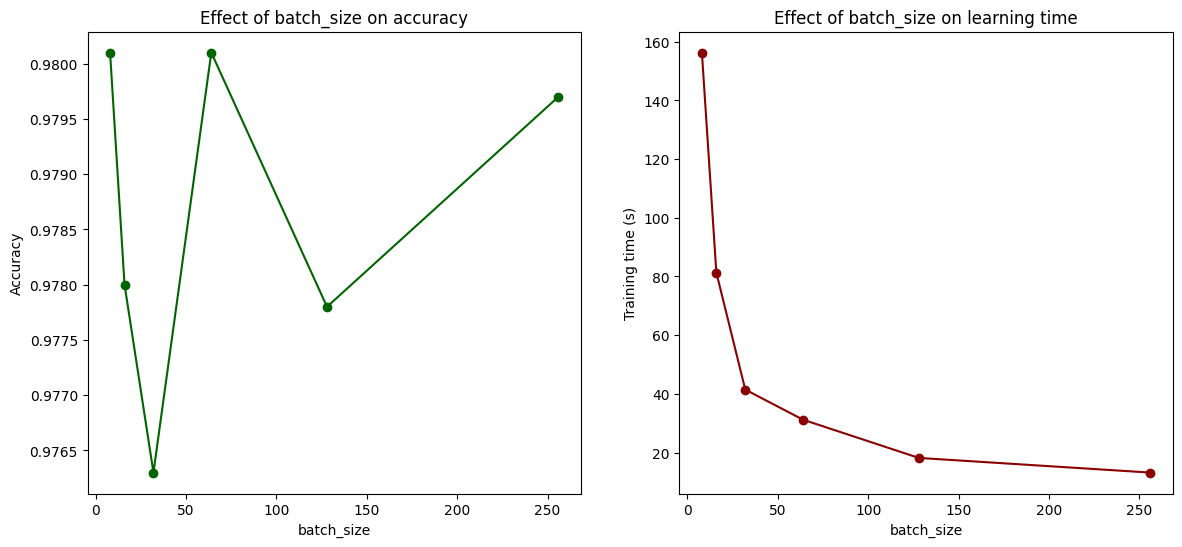

In [78]:
batch_sizes = [result['batch_size'] for result in results]
accuracies = [result['test_accuracy'] for result in results]
training_times = [result['training_time'] for result in results]

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(batch_sizes, accuracies, marker='o', color = "darkgreen")
plt.title('Effect of batch_size on accuracy')
plt.xlabel('batch_size')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(batch_sizes, training_times, marker='o', color='darkred')
plt.title('Effect of batch_size on learning time')
plt.xlabel('batch_size')
plt.ylabel('Training time (s)')

plt.show()

### Analysis of results

In [79]:
for result in results:
    print(f"Batch size: {result['batch_size']}")
    print(f"Test accuracy: {result['test_accuracy']}")
    print(f"Training time: {result['training_time']} seconds")
    print("-" * 30)

print("Analiza wykazała, że optymalna wartość parametru batch_size zależy od kompromisu między czasem nauki a dokładnością. Zbyt małe wartości batch_size mogą prowadzić do dłuższego czasu nauki, natomiast zbyt duże mogą obniżyć dokładność. Wybór optymalnej wartości batch_size powinien być dostosowany do specyfiki problemu oraz zasobów sprzętowych.")
print("The analysis showed that the optimal value of the batch_size parameter depends on the trade-off between learning time and accuracy. Too small values of batch_size can lead to longer learning time, while too large values can reduce accuracy. The choice of the optimal batch_size value should be tailored to the specific problem and hardware resources.")


Batch size: 8
Test accuracy: 0.9800999760627747
Training time: 156.29984641075134 seconds
------------------------------
Batch size: 16
Test accuracy: 0.9779999852180481
Training time: 81.31651210784912 seconds
------------------------------
Batch size: 32
Test accuracy: 0.9763000011444092
Training time: 41.43698501586914 seconds
------------------------------
Batch size: 64
Test accuracy: 0.9800999760627747
Training time: 31.171918153762817 seconds
------------------------------
Batch size: 128
Test accuracy: 0.9778000116348267
Training time: 18.15877914428711 seconds
------------------------------
Batch size: 256
Test accuracy: 0.9797000288963318
Training time: 13.162461757659912 seconds
------------------------------
Analiza wykazała, że optymalna wartość parametru batch_size zależy od kompromisu między czasem nauki a dokładnością. Zbyt małe wartości batch_size mogą prowadzić do dłuższego czasu nauki, natomiast zbyt duże mogą obniżyć dokładność. Wybór optymalnej wartości batch_size 

## CONVOLUTIONAL NEURAL NETWORK

In [47]:
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, Flatten
from keras.layers import BatchNormalization

In [48]:
# Reload the MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [49]:
X_train = X_train.reshape(60000, 28, 28, 1) #add an additional dimension to represent the single-channel
X_test = X_test.reshape(10000, 28, 28, 1)

X_train = X_train.astype('float32')         # change integers to 32-bit floating point numbers
X_test = X_test.astype('float32')

X_train /= 255                              # normalize each value for each pixel for the entire vector for each input
X_test /= 255

print("Training matrix shape", X_train.shape)
print("Testing matrix shape", X_test.shape)

Training matrix shape (60000, 28, 28, 1)
Testing matrix shape (10000, 28, 28, 1)


### One hot encoding

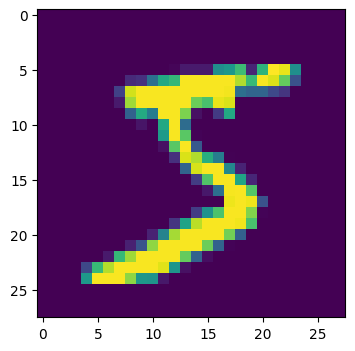

In [50]:
plt.imshow(X_train[0,:,:])

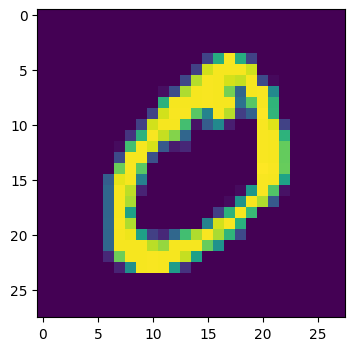

In [51]:
plt.imshow(X_train[1,:,:])

In [52]:
nb_classes = 10 # number of unique digits

Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

## Create Convolutional Model

In [53]:
model = Sequential()

#Convolution Layer 1
model.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
convLayer01 = Activation('relu')
model.add(convLayer01)

#Convolution Layer 2
model.add(Conv2D(32, (3, 3)))        
model.add(Activation('relu'))
convLayer02 = MaxPooling2D(pool_size=(2,2))
model.add(convLayer02)

#Convolution Layer 3
model.add(Conv2D(64,(3, 3)))
convLayer03 = Activation('relu')
model.add(convLayer03)

#Convolution Layer 4
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
convLayer04 = MaxPooling2D(pool_size=(2,2))
model.add(convLayer04)

#Flatten image
model.add(Flatten())

#Fully Connected Layer 5
model.add(Dense(512))               
model.add(Activation('relu'))

#Fully Connected Layer 6
model.add(Dense(10))
model.add(Activation('softmax'))

#Summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 activation_15 (Activation)  (None, 26, 26, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 activation_16 (Activation)  (None, 24, 24, 32)        0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 10, 10, 64)        18496     
                                                      

### Model compile

In [54]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

## Image (data) augmentation

In [55]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                         height_shift_range=0.08, zoom_range=0.08)

test_gen = ImageDataGenerator()

train_generator = gen.flow(X_train, Y_train, batch_size=128)
test_generator = test_gen.flow(X_test, Y_test, batch_size=128)

### Train the model

In [56]:
model.fit_generator(train_generator, steps_per_epoch=60000//128, epochs=2, verbose=1,
                    validation_data=test_generator, validation_steps=10000//128)

Epoch 1/2


C:\Users\Piotrek\AppData\Local\Temp\ipykernel_12328\2580552710.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, steps_per_epoch=60000//128, epochs=2, verbose=1,


468/468 [==============================] - 50s 106ms/step - loss: 0.2538 - accuracy: 0.9196 - val_loss: 0.0385 - val_accuracy: 0.9864
Epoch 2/2
468/468 [==============================] - 52s 111ms/step - loss: 0.0690 - accuracy: 0.9785 - val_loss: 0.0314 - val_accuracy: 0.9895


In [57]:
score = model.evaluate(X_test, Y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

313/313 [==============================] - 3s 8ms/step - loss: 0.0314 - accuracy: 0.9895
Test score: 0.03137132525444031
Test accuracy: 0.9894999861717224


## Visualisation of convolutional filters

In [58]:
for i in range(len(model.layers)):
  layer = model.layers[i]
  # check for convolutional layer
  if 'conv' not in layer.name:
    continue
  # summarize output shape
  print(i, layer.name, layer.output.shape)
  filters, biases = layer.get_weights()
  print(layer.name, filters.shape)

0 conv2d_4 (None, 26, 26, 32)
conv2d_4 (3, 3, 1, 32)
2 conv2d_5 (None, 24, 24, 32)
conv2d_5 (3, 3, 32, 32)
5 conv2d_6 (None, 10, 10, 64)
conv2d_6 (3, 3, 32, 64)
7 conv2d_7 (None, 8, 8, 64)
conv2d_7 (3, 3, 64, 64)


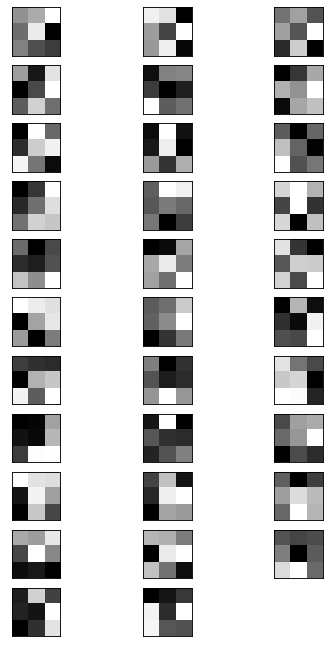

In [59]:
from matplotlib import pyplot
from matplotlib.pyplot import figure

figure(figsize=(6, 30), dpi=80)

filters, biases = model.layers[0].get_weights()

f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
n_filters, ix = 32, 1
for i in range(n_filters):
  f = filters[:, :, :, i]
  for j in range(1):
    ax = pyplot.subplot(n_filters, 3, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    pyplot.imshow(f[:, :, j], cmap='gray')
  ix += 1
pyplot.show()

## Reinstall the newest versions of tf and keras

In [36]:
!pip uninstall tensorflow keras -y
!pip install tensorflow keras

Found existing installation: tensorflow 2.8.0
Uninstalling tensorflow-2.8.0:
  Successfully uninstalled tensorflow-2.8.0
Found existing installation: keras 2.8.0
Uninstalling keras-2.8.0:
  Successfully uninstalled keras-2.8.0


You can safely remove it manually.


  Using cached keras-3.4.1-py3-none-any.whl.metadata (5.8 kB)
  Using cached tensorboard-2.16.2-py3-none-any.whl.metadata (1.6 kB)
  Using cached tensorboard_data_server-0.7.2-py3-none-any.whl.metadata (1.1 kB)
Using cached keras-3.4.1-py3-none-any.whl (1.1 MB)
Using cached tensorboard-2.16.2-py3-none-any.whl (5.5 MB)
Using cached tensorboard_data_server-0.7.2-py3-none-any.whl (2.4 kB)
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.6.1
    Uninstalling tensorboard-data-server-0.6.1:
      Successfully uninstalled tensorboard-data-server-0.6.1
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
